In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate
import warnings
from sklearn_genetic import GASearchCV
from sklearn_genetic.space import Categorical, Integer, Continuous
from sklearn.metrics import make_scorer
from sklearn.linear_model import SGDRegressor,Ridge
from sklearn.model_selection import train_test_split,  cross_validate
from sklearn.preprocessing import StandardScaler
import time
import sys, os
from sklearn.pipeline import make_pipeline


path = 'datasets/Dataset_2.xlsx'

# Read and load dataset
df= pd.read_excel(path, sheet_name="preproc")


/home/ubuntu/Desktop/Demetra/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


INPUT DATA

In [2]:
X = (df.iloc[:,14:]).values
print(X.shape)
std_scaler = StandardScaler()

(2905, 530)


OUTPUT DATA

In [3]:
Y = (df.iloc[:,7]).values
print(Y.shape)

(2905,)


**NRMSEPiqr**

In [4]:


def NRMSEPiqr(observed_values, predicted_values):
    # Calculate RMSEP
    rmsep = np.sqrt(np.mean((observed_values - predicted_values) ** 2))
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = np.percentile(observed_values, 25)
    Q3 = np.percentile(observed_values, 75)

    # Calculate IQR
    IQR = Q3 - Q1

    return rmsep/IQR

NRMSEPiqrscorer = make_scorer(NRMSEPiqr,greater_is_better=False)


**RIDGE REGRESSION with closed form solution NRMSEPiqr**

0.25 ripartition
Trial: 1
Trial: 2
Trial: 3
Trial: 4
Trial: 5
Trial: 6
Trial: 7
Trial: 8
Trial: 9
Trial: 10
Trial: 11
Trial: 12
Trial: 13
Trial: 14
Trial: 15
Trial: 16
Trial: 17
Trial: 18
Trial: 19
Trial: 20
Trial: 21
Trial: 22
Trial: 23
Trial: 24
Trial: 25
Trial: 26
Trial: 27
Trial: 28
Trial: 29
Trial: 30
Trial: 31
Trial: 32
Trial: 33
Trial: 34
Trial: 35
Trial: 36
Trial: 37
Trial: 38
Trial: 39
Trial: 40
Trial: 41
Trial: 42
Trial: 43
Trial: 44
Trial: 45
Trial: 46
Trial: 47
Trial: 48
Trial: 49
Trial: 50
Trial: 51
Trial: 52
Trial: 53
Trial: 54
Trial: 55
Trial: 56
Trial: 57
Trial: 58
Trial: 59
Trial: 60
Trial: 61
Trial: 62
Trial: 63
Trial: 64
Trial: 65
Trial: 66
Trial: 67
Trial: 68
Trial: 69
Trial: 70
Trial: 71
Trial: 72
Trial: 73
Trial: 74
Trial: 75
Trial: 76
Trial: 77
Trial: 78
Trial: 79
Trial: 80
Trial: 81
Trial: 82
Trial: 83
Trial: 84
Trial: 85
Trial: 86
Trial: 87
Trial: 88
Trial: 89
Trial: 90
Trial: 91
Trial: 92
Trial: 93
Trial: 94
Trial: 95
Trial: 96
Trial: 97
Trial: 98
Trial: 99
Tr

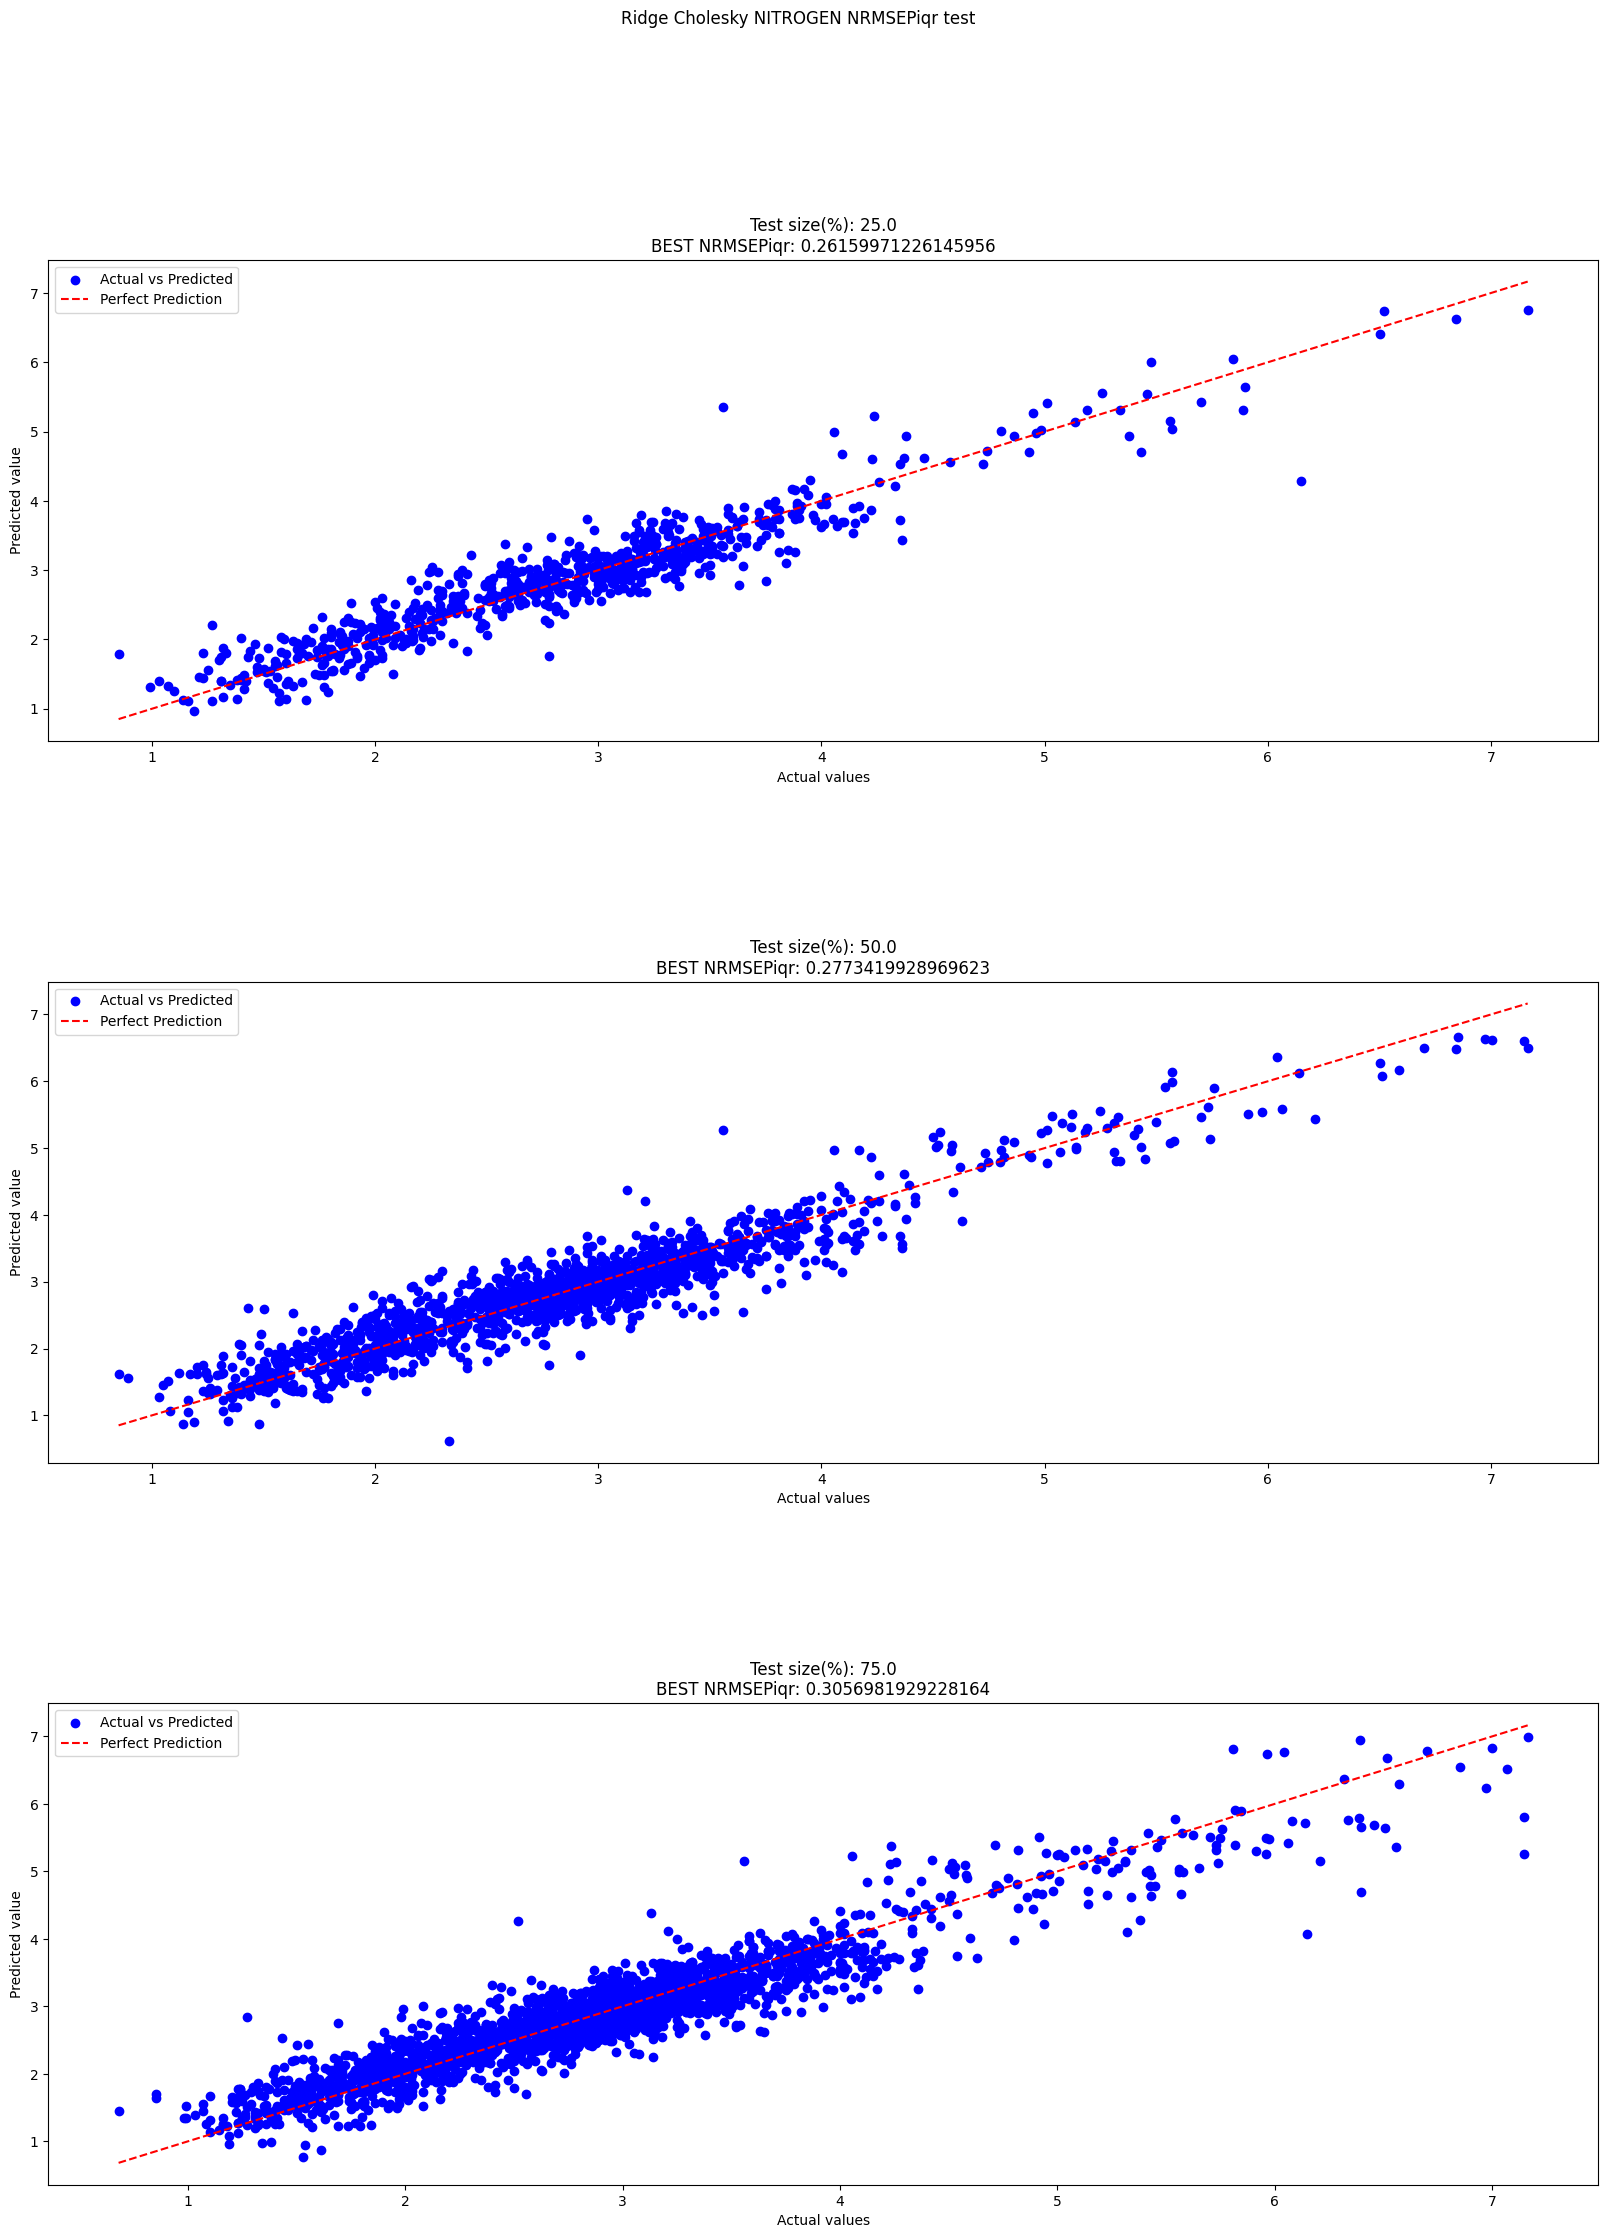

In [4]:



if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" 

#number of trials
trials = 100
np.random.seed(42)
seeds = np.random.randint(trials, size=trials)

ripartisions = [0.25,0.5,0.75]
results = []  

# create 3x1 subfigs
fig, axs = plt.subplots(3, 1,figsize=(20, 25),gridspec_kw={'hspace': 0.5})
fig.suptitle('Ridge Cholesky NITROGEN NRMSEPiqr test'+"\n")
axs = axs.flatten()
k = 0

for ripartition in ripartisions:

        NRMSEP = []

        best_NRMSEP = 100000000
        best_data_1 = {"Y_test":None, "Y_pred":None,"alpha":None,"seed":None}

        run_name = str(ripartition) + " ripartition"
        print(run_name)
        for i in range(trials):
            print("Trial:",i+1)
            #Ripartition in training and test and
            X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=ripartition, random_state=seeds[i])
            X_train= std_scaler.fit_transform(X_train)
            X_test= std_scaler.transform(X_test)
            param_grid = {'alpha': Continuous(1/100000,0.01)}
            ridge_reg_cl = Ridge(solver="cholesky")
            
            evolved_estimator = GASearchCV(estimator=ridge_reg_cl,
                                  cv=5,
                                  scoring=NRMSEPiqrscorer,
                                  param_grid=param_grid,
                                  n_jobs=-1,
                                  verbose=False,
                                  population_size=10,
                                  generations=10,
                                  criteria = "min")
            
            start_time = time.time()
            evolved_estimator.fit(X_train, Y_train)
            elapsed_time = (time.time() -start_time) #elapsed time in seconds
    
            # Make predictions using the testing set
            Y_pred_ridge_cl =  evolved_estimator.best_estimator_.predict(X_test)
    
            #save NRMSEP of the first parameters
            NRMSEP.append(NRMSEPiqr(Y_test, Y_pred_ridge_cl))
    
            #check if this is the best model in terms of MSE
            if NRMSEP[-1] < best_NRMSEP:
              best_NRMSEP = NRMSEP[-1]
              best_data_1["Y_test"] = Y_test
              best_data_1["Y_pred"] = Y_pred_ridge_cl
              best_data_1["alpha"] =  float(evolved_estimator.best_params_["alpha"])
              best_data_1["seed"] = seeds[i]
              best_data_1["model"] = evolved_estimator.best_estimator_
              best_data_1["time"] = elapsed_time


        results.append([str(ripartition *100 ), str(best_NRMSEP),
                        (np.mean(NRMSEP)), str(np.var(NRMSEP)),
                        str(best_data_1["alpha"]),best_data_1["seed"],best_data_1["time"]])

        '''PLOT THE BEST MODELS'''
        axs[k].scatter(best_data_1["Y_test"], best_data_1["Y_pred"], c='blue', label='Actual vs Predicted')
        axs[k].plot([min(best_data_1["Y_test"]), max(best_data_1["Y_test"])],
                    [min(best_data_1["Y_test"]), max(best_data_1["Y_test"])], '--', c='red', label='Perfect Prediction')
        axs[k].legend()
        axs[k].set_xlabel("Actual values")
        axs[k].set_ylabel("Predicted value")
        axs[k].set_title( f"Test size(%): {ripartition * 100}" "\n" + "BEST NRMSEPiqr: " + results[k][1] )
        k += 1


'''SHOW RESULTS'''

headers = ["Test size(%)", "Best(NRMSEPiqr)", "Mean(NRMSEPiqr)", "Var(NRMSEPiqr)","alpha","Seed","Time(sec)"]

print(tabulate(results, headers,  tablefmt="double_outline"))



**RIDGE closed form K-fold CV**

gen	nevals	fitness  	fitness_std	fitness_max	fitness_min
0  	50    	-0.292175	0.00198566 	-0.289374  	-0.295508  
1  	100   	-0.29412 	0.00122511 	-0.291114  	-0.295508  
2  	100   	-0.294724	0.00072069 	-0.292888  	-0.295524  
3  	100   	-0.295009	0.000617239	-0.293346  	-0.295524  
4  	100   	-0.295081	0.00082592 	-0.291527  	-0.295563  
5  	100   	-0.295211	0.000693989	-0.292814  	-0.29554   
6  	100   	-0.295152	0.000818263	-0.292511  	-0.295576  
7  	100   	-0.295157	0.000877418	-0.291619  	-0.295576  
8  	100   	-0.295183	0.000787476	-0.291934  	-0.295576  
9  	100   	-0.295196	0.000988177	-0.289694  	-0.295576  
10 	100   	-0.295232	0.000644731	-0.293044  	-0.295576  
11 	100   	-0.295297	0.000600788	-0.29307   	-0.295577  
12 	100   	-0.295388	0.000533771	-0.29307   	-0.295576  
13 	100   	-0.295331	0.000769251	-0.291112  	-0.295577  
14 	100   	-0.295407	0.000521608	-0.292322  	-0.295577  
15 	100   	-0.295315	0.000737768	-0.291271  	-0.295577  
16 	100   	-0.295385	0.00049290

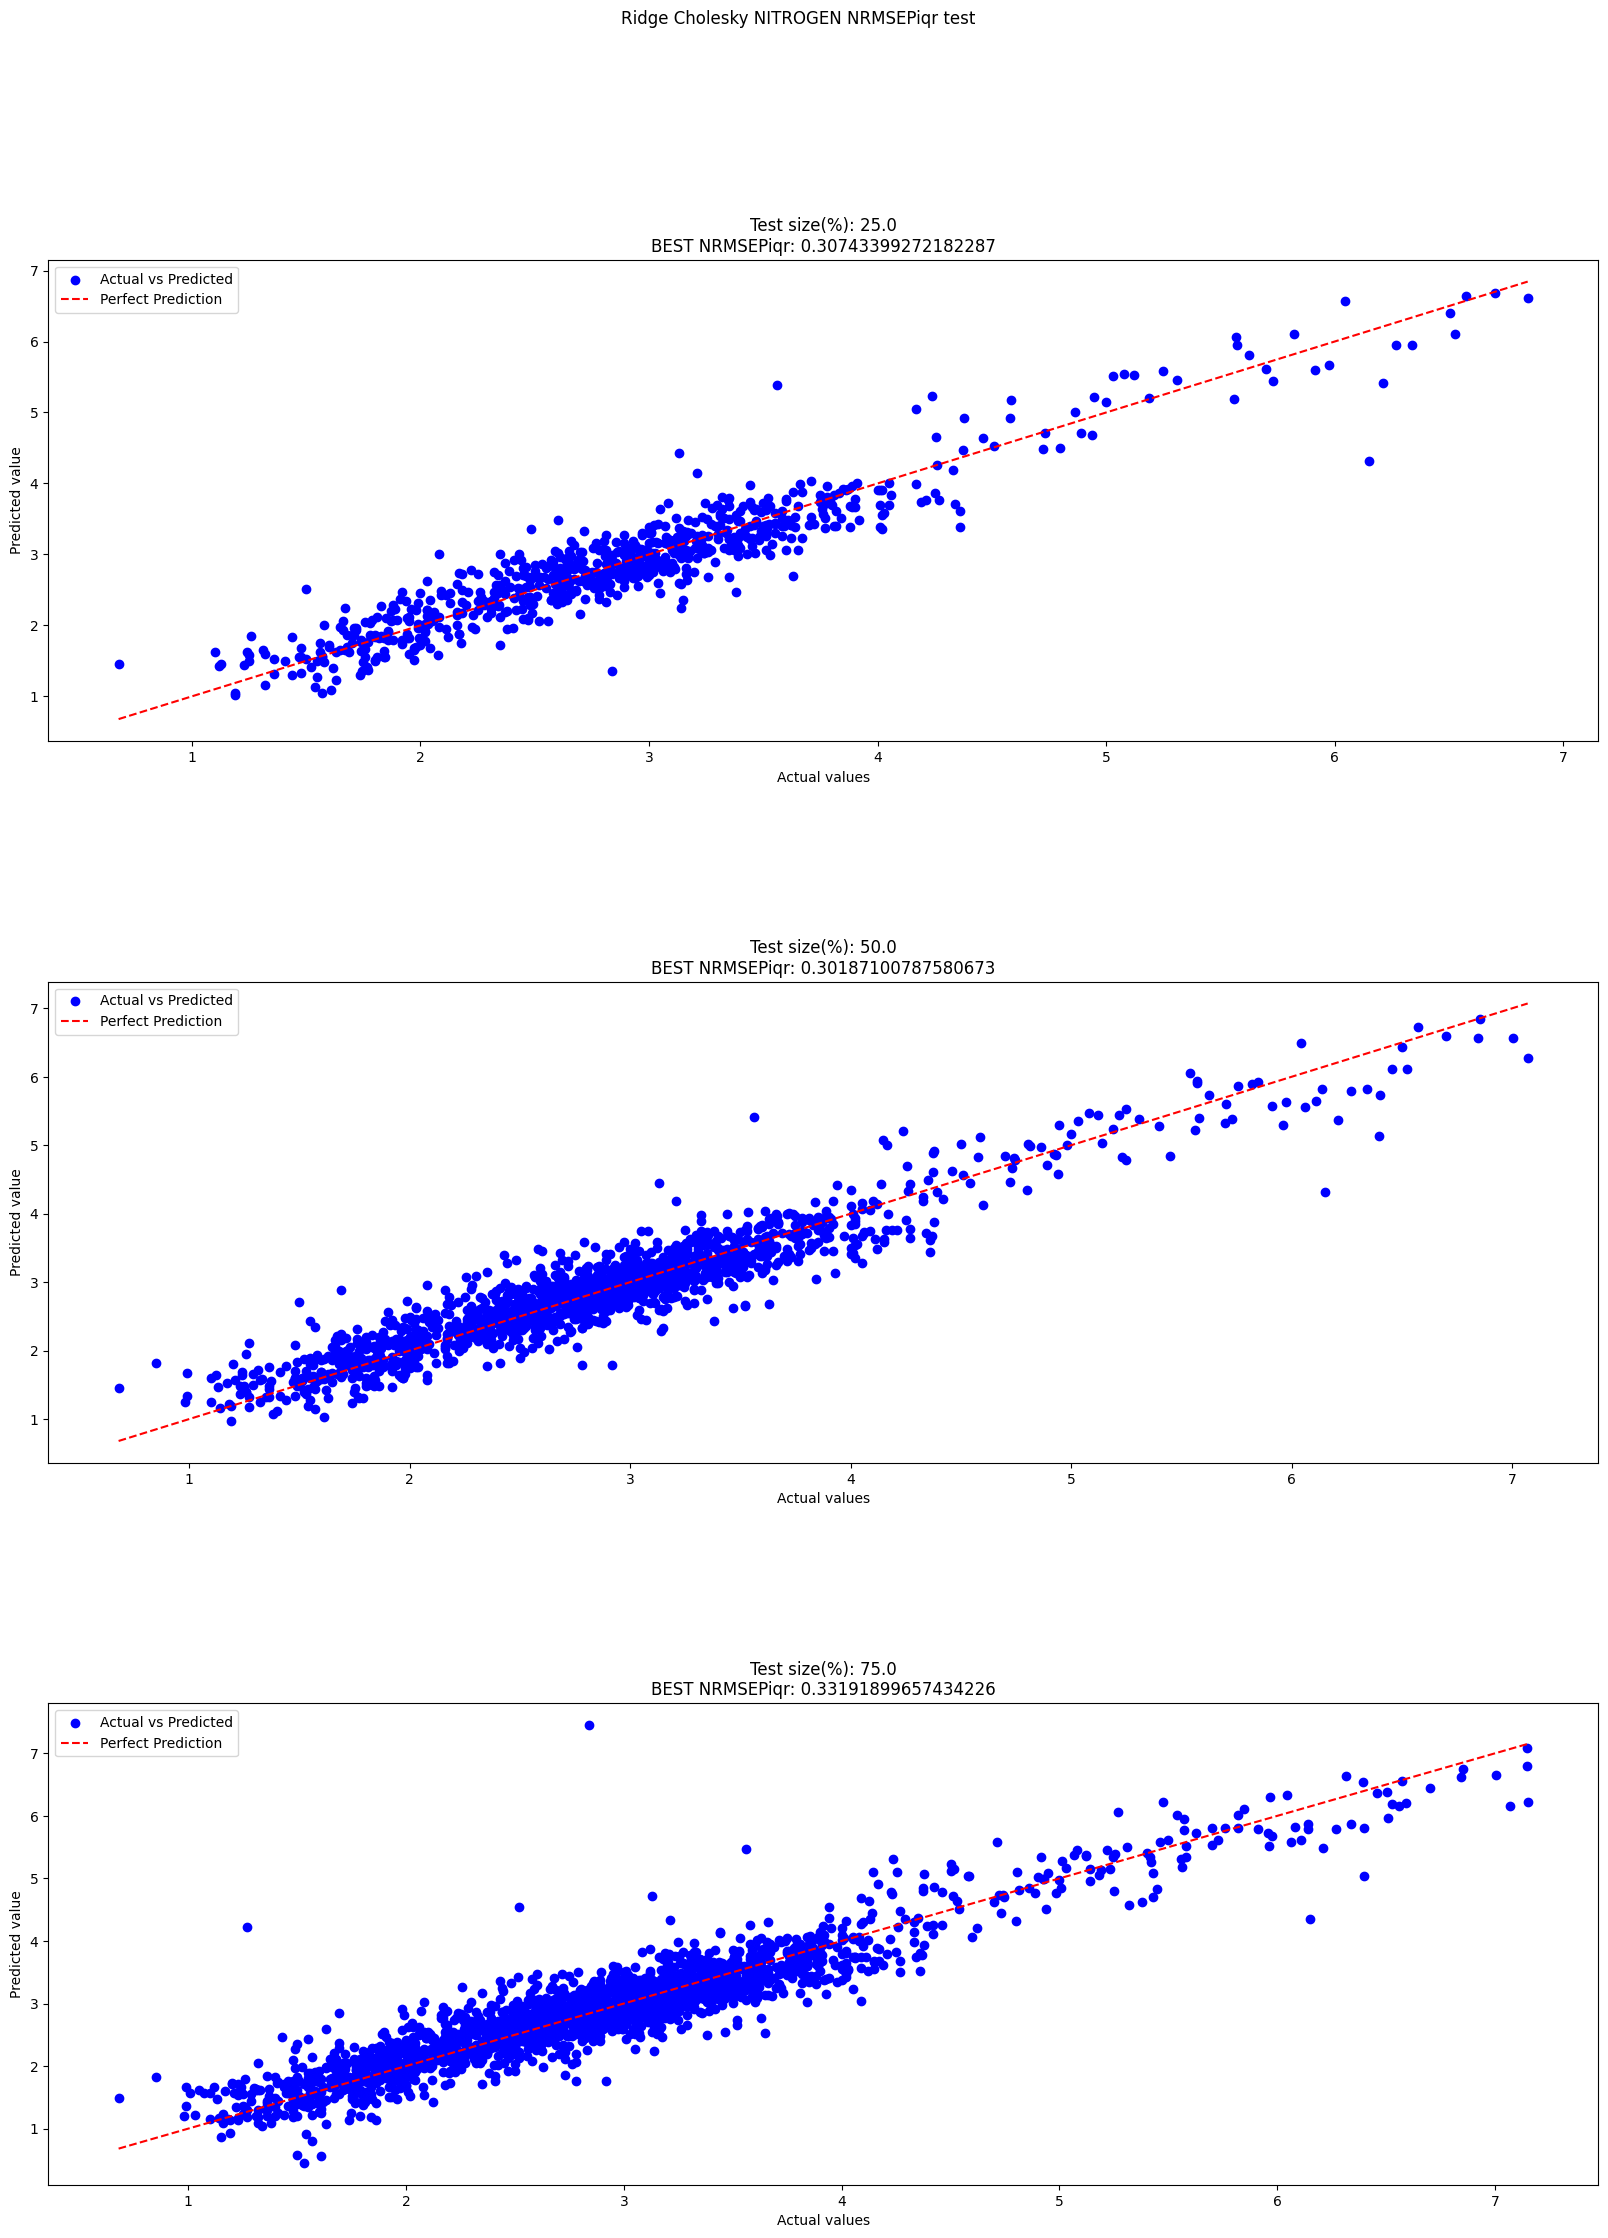

In [5]:

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" 

#number of trials
trials = 100
np.random.seed(42)
seeds = np.random.randint(trials, size=trials)

ripartisions = [0.25,0.5,0.75]
results = []  

# create 3x1 subfigs
fig, axs = plt.subplots(3, 1,figsize=(20, 25),gridspec_kw={'hspace': 0.5})
fig.suptitle('Ridge Cholesky NITROGEN NRMSEPiqr test'+"\n")
axs = axs.flatten()
k = 0

for ripartition in ripartisions:

    NRMSEP = []

    best_NRMSEP = 100000000
    best_data_1 = {"Y_test":None, "Y_pred":None,"alpha":None,"seed":None}

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=ripartition, random_state=42) 
    param_grid = {'ridge__alpha': Continuous(1/100000,0.01)}
    ridge_pipeline = make_pipeline(StandardScaler(), Ridge(solver="cholesky"))
    sturges = int(1 + np.log(len(X_train)))    
    evolved_estimator = GASearchCV(estimator=ridge_pipeline,
                                  cv=sturges,
                                  scoring=NRMSEPiqrscorer,
                                  param_grid=param_grid,
                                  n_jobs=-1,
                                  verbose=True,
                                  population_size=50,
                                  generations=100,
                                  criteria = "min")
    

    start_time = time.time()
    evolved_estimator.fit(X_train, Y_train)
    elapsed_time = (time.time() -start_time) #elapsed time in seconds

    print("Best vaue of alpha: ", str(evolved_estimator.best_params_["ridge__alpha"]))

    best_model =  evolved_estimator.best_estimator_
    cv_scores = cross_validate(best_model, X_train, Y_train, cv=sturges, scoring=NRMSEPiqrscorer,n_jobs=-1)      
    Y_pred_ridge_cl = best_model.predict(X_test)


    # Display results
    print("Cross-validation NRMSEPiqr scores:", cv_scores['test_score'])
    print("Training times (seconds):", cv_scores['fit_time'])
    print("Scoring times (seconds):", cv_scores['score_time'])
    print("Final training time (seconds):", elapsed_time)
    print("Final NRMSEPiqr: ",  NRMSEPiqr(Y_test, Y_pred_ridge_cl))


           
    '''PLOT THE FINAL MODELS'''
    axs[k].scatter(Y_test, Y_pred_ridge_cl, c='blue', label='Actual vs Predicted')
    axs[k].plot([min(Y_test), max(Y_test)],
                    [min(Y_test), max(Y_test)], '--', c='red', label='Perfect Prediction')
    axs[k].legend()
    axs[k].set_xlabel("Actual values")
    axs[k].set_ylabel("Predicted value")
    axs[k].set_title( f"Test size(%): {ripartition * 100}" "\n" + "BEST NRMSEPiqr: " + str(NRMSEPiqr(Y_test, Y_pred_ridge_cl) ))
    k += 1




**RIDGE REGRESSION with SGD NRMSEPiqr**

In [ ]:


if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" 


def NRMSEPiqr(observed_values, predicted_values):
    # Calculate RMSEP
    rmsep = np.sqrt(np.mean((observed_values - predicted_values) ** 2))
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = np.percentile(observed_values, 25)
    Q3 = np.percentile(observed_values, 75)

    # Calculate IQR
    IQR = Q3 - Q1

    return rmsep/IQR

NRMSEPiqrscorer = make_scorer(NRMSEPiqr,greater_is_better=False)


#number of trials
trials = 100
np.random.seed(42)
seeds = np.random.randint(trials, size=trials)

ripartisions = [0.25, 0.5, 0.75]
results = [] 

# create 3x1 subfigs
fig, axs = plt.subplots(3, 1,figsize=(20, 25),gridspec_kw={'hspace': 0.5})
fig.suptitle('Ridge regression SGD NITROGEN NRMSEPiqr test'+"\n")
axs = axs.flatten()
k = 0

for ripartition in ripartisions:



        NRMSEP = []

        best_NRMSEP = 100000000
        best_data_1 = {"Y_test":None, "Y_pred":None,"alpha":None,"seed":None}

        run_name = str(ripartition) + " ripartition"
        print(run_name)
  
        i = 0
        for i in range(trials):
            print("Trial: ", i+1)
            #Ripartition in training and test and
            X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=ripartition, random_state=seeds[i])
            X_train= std_scaler.fit_transform(X_train)
            X_test= std_scaler.transform(X_test)
            param_grid = {'alpha': Continuous(1/100000,0.01)}
            ridge_reg_sgd = SGDRegressor(max_iter=5000, tol=1e-5, penalty="l2", eta0=0.01,
                                                n_iter_no_change=10, random_state=42)
    
            evolved_estimator = GASearchCV(estimator=ridge_reg_sgd,
                                  cv=5,
                                  scoring=NRMSEPiqrscorer,
                                  param_grid=param_grid,
                                  n_jobs=-1,
                                  verbose=True,
                                  population_size=10,
                                  generations=10,
                                  criteria = "min")
    
            start_time = time.time()
            evolved_estimator.fit(X_train, Y_train)
            elapsed_time = (time.time() -start_time) #elapsed time in seconds
    
            # Make predictions using the testing set
            Y_pred_ridge_sgd =  evolved_estimator.predict(X_test)
    
            #save MSE of the first parameters
            NRMSEP.append(NRMSEPiqr(Y_test, Y_pred_ridge_sgd))
    
            #check if this is the best model in terms of MSE
            if NRMSEP[-1] < best_NRMSEP:
                best_NRMSEP = NRMSEP[-1]
                best_data_1["Y_test"] = Y_test
                best_data_1["Y_pred"] = Y_pred_ridge_sgd
                best_data_1["alpha"] = float(evolved_estimator.best_params_["alpha"])
                best_data_1["seed"] = seeds[i]
                best_data_1["model"] = evolved_estimator.best_estimator_
                best_data_1["time"] = elapsed_time

        results.append([str(ripartition *100 ), str(best_NRMSEP),
                        (np.mean(NRMSEP)), str(np.var(NRMSEP)),
                        str(best_data_1["alpha"]),best_data_1["seed"],best_data_1["time"]])

        '''PLOT THE BEST MODELS'''
        axs[k].scatter(best_data_1["Y_test"], best_data_1["Y_pred"], c='blue', label='Actual vs Predicted')
        axs[k].plot([min(best_data_1["Y_test"]), max(best_data_1["Y_test"])],
                    [min(best_data_1["Y_test"]), max(best_data_1["Y_test"])], '--', c='red', label='Perfect Prediction')
        axs[k].legend()
        axs[k].set_xlabel("Actual values")
        axs[k].set_ylabel("Predicted value")
        axs[k].set_title( f"Test size(%): {ripartition * 100}" "\n" + "BEST NRMSEPiqr: " + results[k][1] )
        k += 1


'''SHOW RESULTS'''

headers = ["Test size(%)", "Best(NRMSEPiqr)", "Mean(NRMSEPiqr)", "Var(NRMSEPiqr)","alpha","Seed","Time(sec)"]

print(tabulate(results, headers,  tablefmt="double_outline"))


